## <font color='gray'>Отчет по домашнему заданию 3</font>
###  <font color='gray'>Выполнила:</font> Евсикова Дарья Алексеевна
### <font color='gray'>МОиАД, 1 курс</font>

________________________________

### Задача:

Минимизировать функцию потерь $F_{train} \underset{w}{\rightarrow} min$:

$$F_{train}(w) = - \frac{1}{N}\sum_{i=1}^{N}{y_i}\log{(\sigma_w(x_i))} + (1-y_i)\log{(1-\sigma_w(x_i))},$$
где $\sigma_w(x) = \dfrac{e^{w^{T}x}}{1 + e^{w^{T}x}}$

In [1]:
import oracle
import optimize as opt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from tabulate import tabulate
plt.style.use('ggplot')

In [2]:
my_oracle = oracle.make_oracle(data_path='data/a1a.txt')

Сразу же __определим бенчмарк__ для решаемой задачи, посчитав кросс-энтропию для логистической регрессии из `sklearn`

Будем использовать полученное значение в качестве $F(w_*)$ при анализе динамики $r_k$

In [3]:
X = my_oracle._X
y = my_oracle._y
lr = LogisticRegression(penalty='none', max_iter=1000).fit(X, np.ravel(y))
benchmark = log_loss(y, lr.predict_proba(X))
print('Optimal entropy:', benchmark)

Optimal entropy: 0.2978757199669842


<br>

Инициализируем функции для __построения графиков__:

In [7]:
def stats_for_plot(f, w, method='gd'):
    stats = dict()
    if method == 'gd':
        optimizer = opt.OptimizeGD()
        methods = (['wolfe', 'lipschitz'])
        max_iter = 10000
    elif method == 'newton':
        optimizer = opt.OptimizeNewton()
        methods = (['armijo'])
        max_iter = 500
    elif method == 'hfn':
        optimizer = opt.OptimizeHFN()
        policies = (['sqrtGradNorm', 'gradNorm'])
        max_iter = 300
    elif method == 'lbfgs':
        optimizer = opt.OptimizeLBFGS()
        hsize = (3, 10, 15, 20, 30, 50)
    else:
        raise ValueError('Incorrect method')
    
    if method == 'hfn':
        for policy in policies:
            d = dict()
            w_opt = optimizer.optimize(f, w, tol=1e-8, policy=policy, tol_eta=0.5, max_iter=max_iter)
            d['func'] = optimizer.func_values
            d['norm_sq'] = optimizer.grad_norm_k
            d['time'] = optimizer.time
            d['calls'] = optimizer.oracle_num_calls
            d['iter'] = optimizer.num_iter
            d['w_opt'] = w_opt
            stats[f'HFN: {policy}'] = d
    
    elif method == 'lbfgs':
        for size in hsize:
            d = dict()
            w_opt = optimizer.lbfgs_optimize(f, w, tolerance=1e-8, history_size=size)
            d['func'] = optimizer.func_values
            d['norm_sq'] = optimizer.grad_norm_k
            d['time'] = optimizer.time
            d['calls'] = optimizer.oracle_num_calls
            d['iter'] = optimizer.num_iter
            d['w_opt'] = w_opt
            stats[f'L-BFGS: hist_size={size}'] = d
            
    else:
        for ls in methods:
            d = dict()
            w_opt = optimizer.optimize(f, w, line_search_method=ls, tol=1e-8, max_iter=max_iter)
            d['func'] = optimizer.func_values
            d['norm_sq'] = optimizer.grad_norm_k
            d['time'] = optimizer.time
            d['calls'] = optimizer.oracle_num_calls
            d['iter'] = optimizer.num_iter
            d['w_opt'] = w_opt
            stats[ls] = d
    
    return stats

def plot_stats(stats, benchmark, plot_type='iter', title='plot'):
    
    '''
        Parameters
        ----------
        plot_type: iter, calls, time
    
    '''
    if plot_type == 'iter':
        x_label = 'Количество итераций'
    elif plot_type == 'calls':
        x_label = 'Количество вызовов оракула'
    elif plot_type == 'time':
        x_label = 'Время работы метода, сек'
    
    
    fig, axs = plt.subplots(1,2, figsize=(16,5))
    
    for linesearch in stats.keys():
        iters = stats[linesearch][plot_type]
        rk1 = stats[linesearch]['norm_sq']
        norm_sq_0 = rk1[0]
        rk1 = np.log(rk1 / norm_sq_0)
        rk2 = stats[linesearch]['func']
        score = np.around(rk2[-1], 6)
        rk2 = np.log(np.absolute(rk2 - benchmark))         
        axs[0].plot(iters, rk1, label = f"{linesearch}: {score}", linewidth=2, linestyle='-')
        axs[1].plot(iters, rk2, label = linesearch, linewidth=3, linestyle='-')
    
    fig.suptitle(title, fontsize=15)

    axs[0].set(xlabel=x_label)
    axs[0].set(ylabel="log $||F(w_k)||^2$ / $||F(w_0)||^2$")
    axs[0].legend(facecolor='white', fontsize=12)

    axs[1].set(xlabel=x_label)
    axs[1].set(ylabel="log $|F(w_k) - F(w*)|$")
    axs[1].legend(facecolor='white', fontsize=12)
    
    plt.show()

## Реализация L-BFGS

Все дальнейшие реализации методов содержатся в файле `optimize.py`

Метод __L-BFGS__ реализован в соответствующем классе: `OptimizeLBFGS`

Вызов функции `optimize` происходит как вызов метода `lbfgs_optimize(args)` для инстанса соответствующего класса

В полях класса хранится статистика работы метода, которые обновляются при каждом запуске `optimize`

<br>

__Рассмотрим работу метода при разных стартовых точках `w`, а также при разных значениях `history_size`__:
1. $w=0$
2. $w=1$
3. $w\sim \mathcal{N}(0,1)$

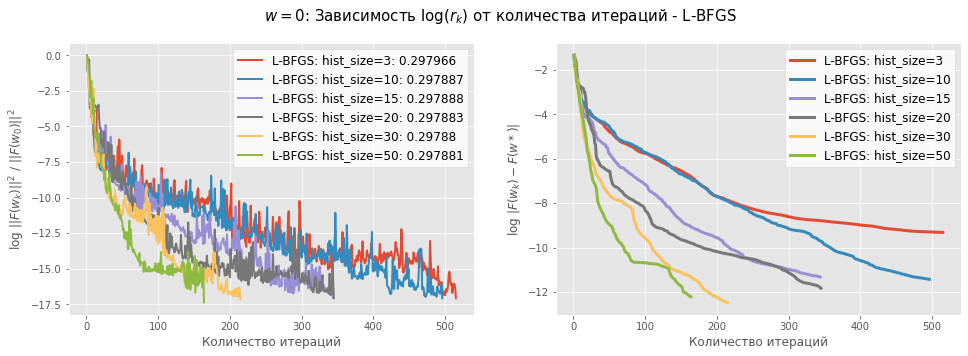

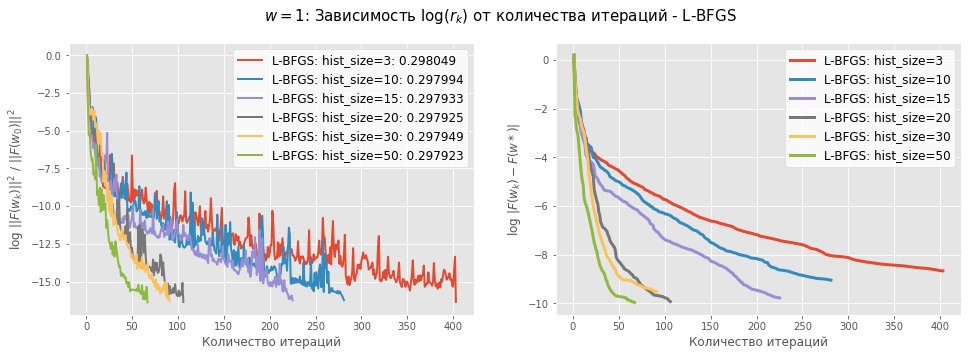

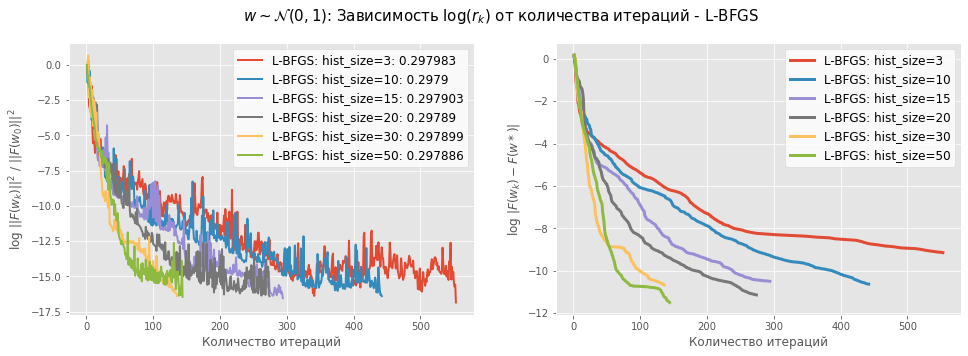

In [9]:
w = np.zeros((my_oracle.num_features, 1))
stats_lbfgs = stats_for_plot(my_oracle, w, method='lbfgs')
plot_stats(stats_lbfgs, benchmark, plot_type='iter', title='$w=0$: Зависимость $\log{(r_k)}$ от количества итераций - L-BFGS')

w = np.ones((my_oracle.num_features, 1))
stats_lbfgs = stats_for_plot(my_oracle, w, method='lbfgs')
plot_stats(stats_lbfgs, benchmark, plot_type='iter', title='$w=1$: Зависимость $\log{(r_k)}$ от количества итераций - L-BFGS')

w = np.random.normal(size=(my_oracle.num_features, 1))
stats_lbfgs = stats_for_plot(my_oracle, w, method='lbfgs')
plot_stats(stats_lbfgs, benchmark, plot_type='iter', 
           title='$w\sim \mathcal{N}(0,1)$: Зависимость $\log{(r_k)}$ от количества итераций - L-BFGS')

__Выводы:__
- Метод L-BFGS сходится для разных начальных значений весов
- При увеличении значения величины `history_size`, очевидно, ускоряется сходимость метода в смысле количества итераций - т.к. вычисления каждый раз базируются на большем количестве ранее посчитанных значений

<br>

__Посмотрим также на остальные графики - количества вызовов оракула и времени - для $w=0$__

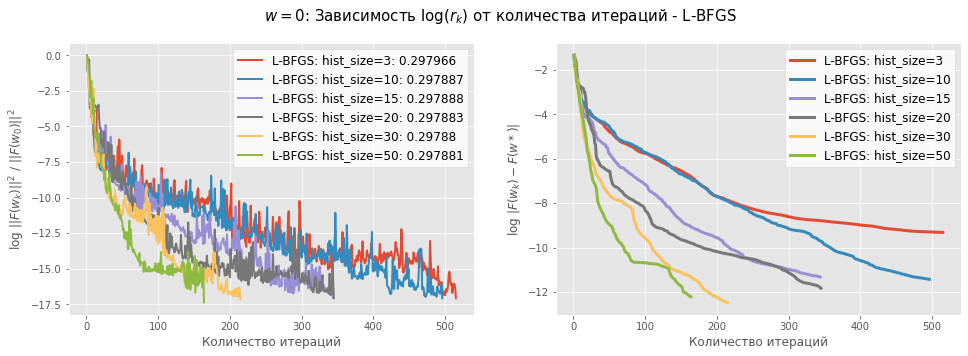

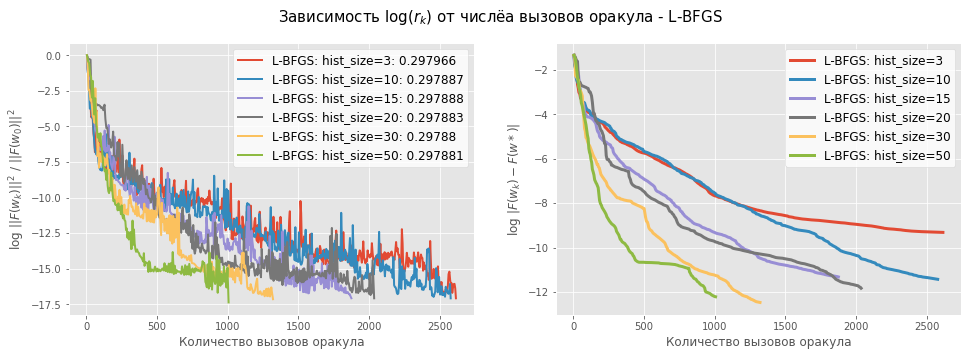

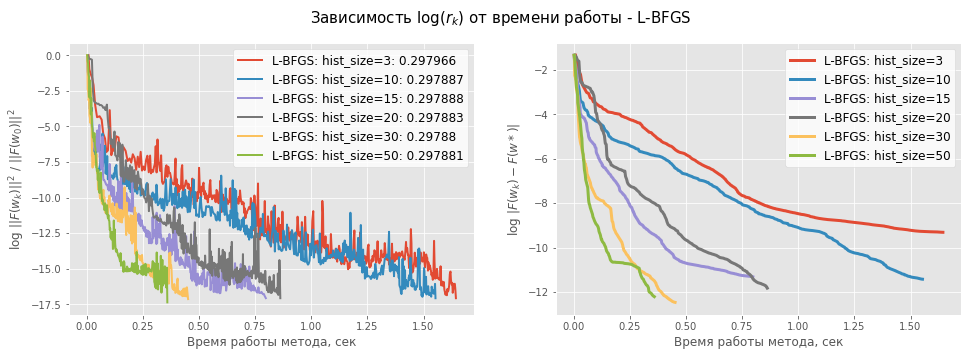

In [10]:
w = np.zeros((my_oracle.num_features, 1))
stats_lbfgs = stats_for_plot(my_oracle, w, method='lbfgs')
plot_stats(stats_lbfgs, benchmark, plot_type='iter', title='$w=0$: Зависимость $\log{(r_k)}$ от количества итераций - L-BFGS')
plot_stats(stats_lbfgs, benchmark, plot_type='calls', title='Зависимость $\log{(r_k)}$ от числёа вызовов оракула - L-BFGS')
plot_stats(stats_lbfgs, benchmark, plot_type='time', title='Зависимость $\log{(r_k)}$ от времени работы - L-BFGS')

__Выводы:__

- При увеличении значения величины `history_size`, очевидно, ускоряется сходимость метода в смысле количества итераций - т.к. вычисления каждый раз базируются на большем количестве ранее посчитанных значений. Он __становится ближе к BFGS__
- Но __применять значения для `history_size` слишком большими - бессмысленно__, т.к. теряется сама суть использования метода. Он предназначен для таких задач, где Гессиан не является `sparse`, и поэтому хранить его целиком в памяти - либо невозможно, либо слишком затратно. И поэтому ни BFGS, ни Ньютона использовать не хотим
- Видим, что и для низких значений параметра `history_size=10`, `history_size=15` __сходимость метода не нарушается__. 
- При низких значениях `history_size` метод сходится за разумное время, а количество вызовов оракула имеет примерно тот же порядок, что и для более высоких значений
- Поэтому __наиболее разумным кажется использование небольших значений `history_size=10; 15; 20`__

## Сравнение с другими методами - датасет a1a

In [11]:
stats_best = dict()
stats_gd = stats_for_plot(my_oracle, w, method='gd')
stats_newton = stats_for_plot(my_oracle, w, method='newton')
stats_hfn = stats_for_plot(my_oracle, w, method='hfn')

stats_best['GD - Wolfe'] = stats_gd['wolfe']
stats_best['Newton - Armijo'] = stats_newton['armijo']
stats_best.update(stats_hfn)
stats_best['L-BFGS - hist_size=15'] = stats_lbfgs['L-BFGS: hist_size=15']

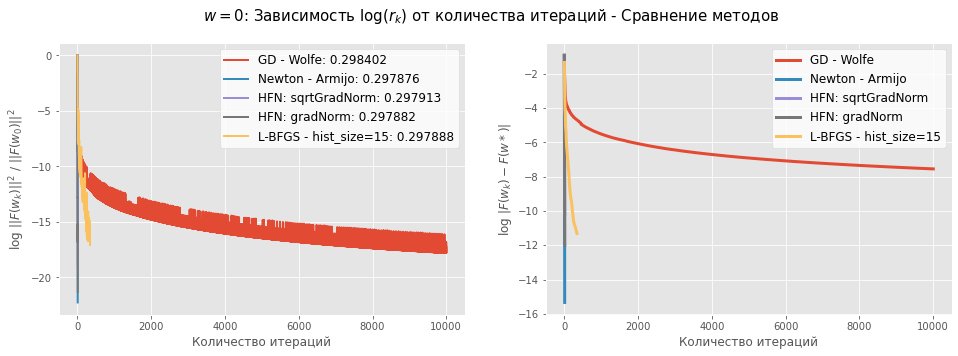

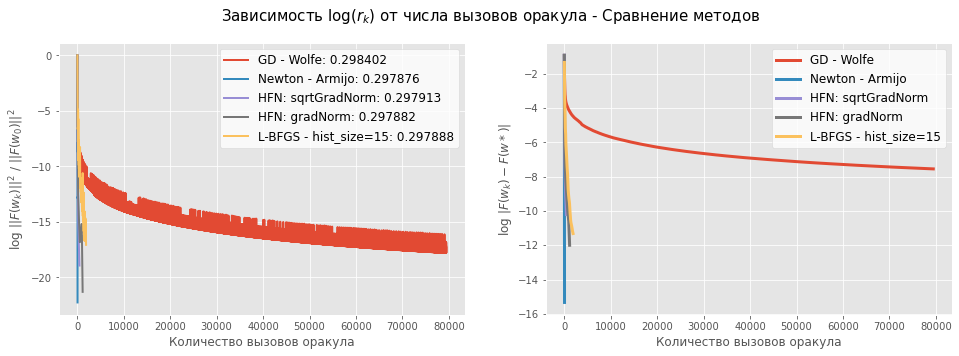

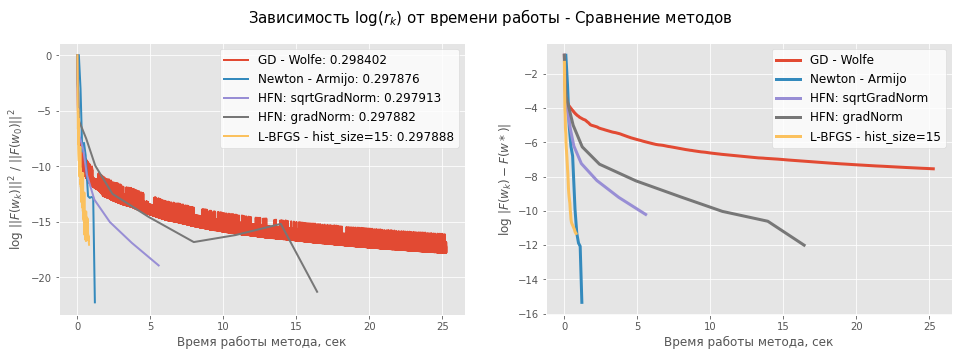

In [12]:
plot_stats(stats_best, benchmark, plot_type='iter', 
           title='$w=0$: Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')
plot_stats(stats_best, benchmark, plot_type='calls', 
           title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - Сравнение методов')
plot_stats(stats_best, benchmark, plot_type='time', 
           title='Зависимость $\log{(r_k)}$ от времени работы - Сравнение методов')

__Посмотрим на графики без градиентного спуска__

In [13]:
del stats_best['GD - Wolfe']

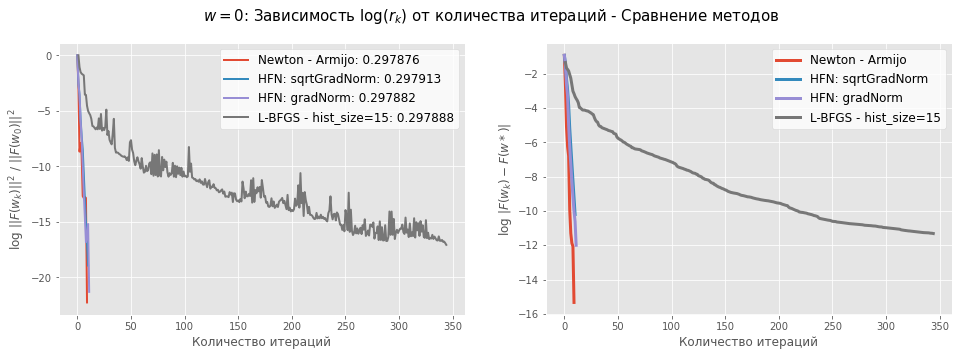

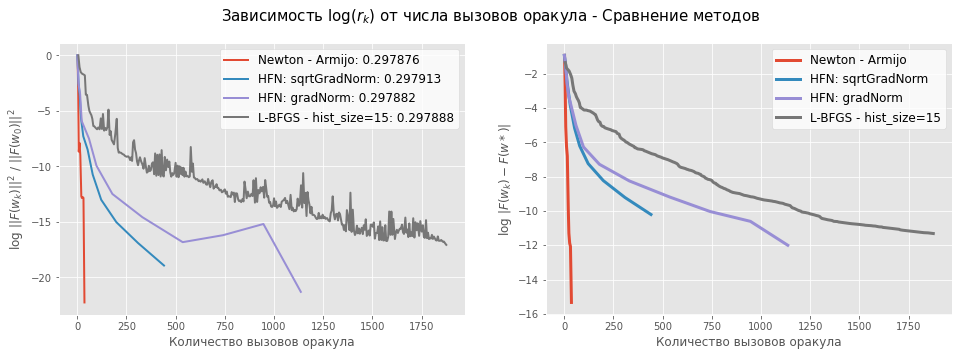

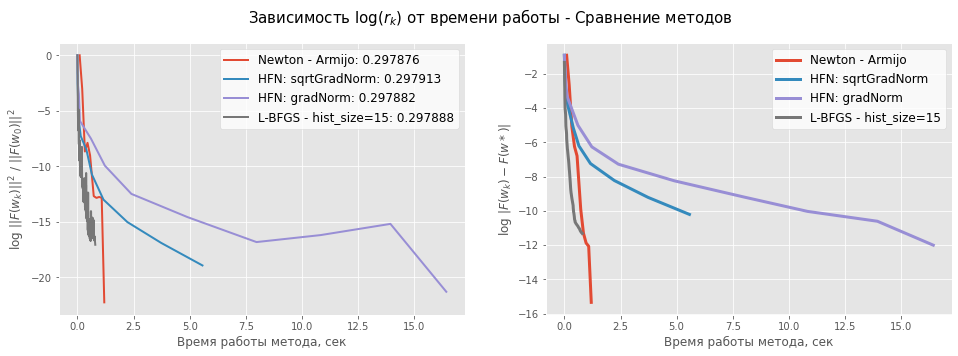

In [14]:
plot_stats(stats_best, benchmark, plot_type='iter', 
           title='$w=0$: Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')
plot_stats(stats_best, benchmark, plot_type='calls', 
           title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - Сравнение методов')
plot_stats(stats_best, benchmark, plot_type='time', 
           title='Зависимость $\log{(r_k)}$ от времени работы - Сравнение методов')

__Выводы:__
- L-BFGS требует большего количества вызовов оракула, а также большее количество итераций до сходимости
- L-BFGS наиболее быстрый среди всех методов по времени
- Для dense гессиана необходимо использовать методы, которые не требуют его хранения в памяти -HFN или L-BFGS
- На данном датасете HFN работает немного медленнее, чем L-BFGS, но требует меньшего числа вызовов оракула
<br><br>

## Дополнительно:


###  Тестирование на датасете breast-cancer

In [15]:
my_oracle = oracle.make_oracle(data_path='data/breast-cancer_scale.txt')

In [16]:
X = my_oracle._X
y = my_oracle._y
lr = LogisticRegression(penalty='none', max_iter=1000).fit(X, np.ravel(y))
benchmark1 = log_loss(y, lr.predict_proba(X))
print('Optimal entropy:', benchmark1)

Optimal entropy: 0.07531873603480535


In [17]:
# start point
w = np.zeros((my_oracle.num_features, 1))

In [18]:
# соберем всю статистику, необходимую для построения графиков 
stats_gd_bc = stats_for_plot(my_oracle, w, method='gd')
stats_newton_bc = stats_for_plot(my_oracle, w, method='newton')
stats_hfn_bc = stats_for_plot(my_oracle, w, method='hfn')
stats_lbfgs_bc = stats_for_plot(my_oracle, w, method='lbfgs')

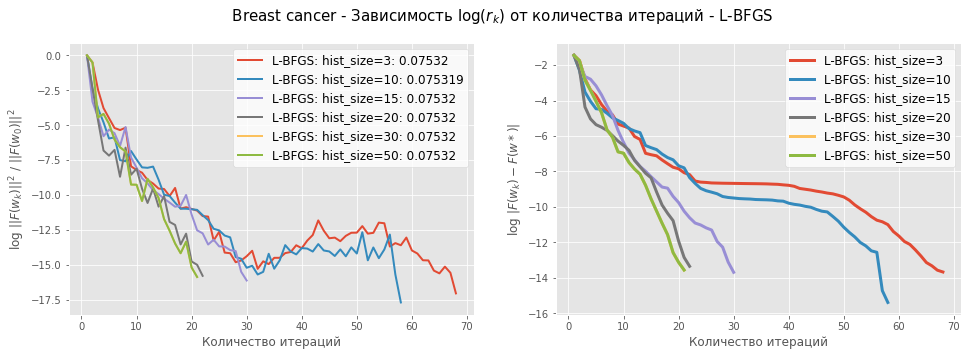

In [19]:
plot_stats(stats_lbfgs_bc, benchmark1, plot_type='iter', 
           title=' Breast cancer - Зависимость $\log{(r_k)}$ от количества итераций - L-BFGS')

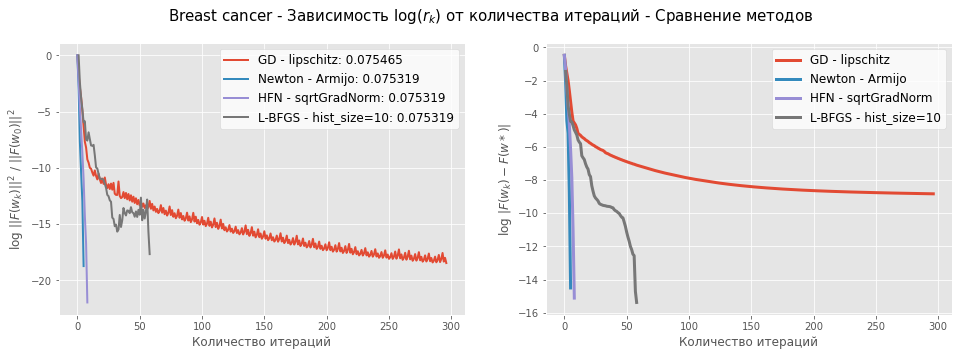

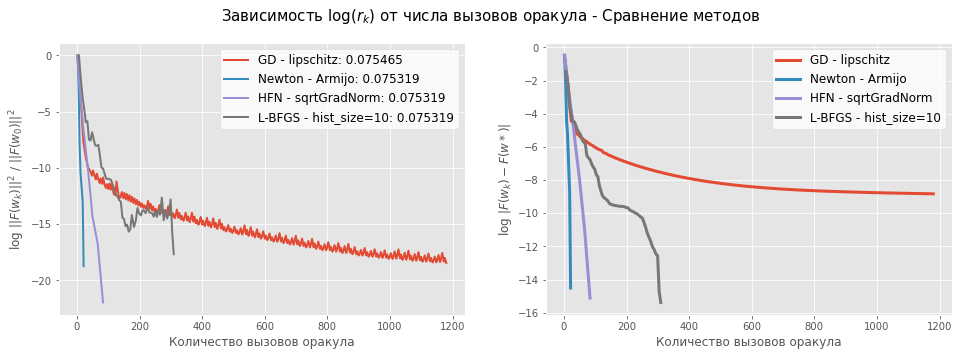

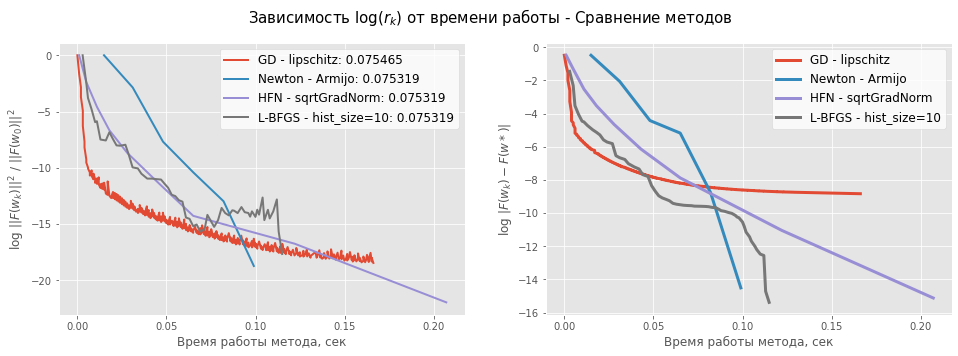

In [20]:
stats_best_bc = dict()
stats_best_bc['GD - lipschitz'] = stats_gd_bc['lipschitz']
stats_best_bc['Newton - Armijo'] = stats_newton_bc['armijo']
stats_best_bc['HFN - sqrtGradNorm'] = stats_hfn_bc['HFN: sqrtGradNorm']
stats_best_bc['L-BFGS - hist_size=10'] = stats_lbfgs_bc['L-BFGS: hist_size=10']
plot_stats(stats_best_bc, benchmark1, plot_type='iter', 
           title='Breast cancer - Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')
plot_stats(stats_best_bc, benchmark1, plot_type='calls', 
           title='Зависимость $\log{(r_k)}$ от числа вызовов оракула - Сравнение методов')
plot_stats(stats_best_bc, benchmark1, plot_type='time', 
           title='Зависимость $\log{(r_k)}$ от времени работы - Сравнение методов')

__Вывод__:
- Результаты примерно аналогичны предыдущему датасету - градиентный спуск проигрывает всем методам
- На таком маленьком датасете логичнее использовать метод Ньютона, т.к. оптимизация памяти здесь не требуется
- L-BFGS показал лучшую точность


###  Тестирование на сгенерированных данных

In [21]:
# a1 * x1 + a2 * x2 + b = y

a1, a2, beta = np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)
X = np.random.normal(loc=0, scale=1, size=(1000, 2))
X = np.hstack((X, np.ones((X.shape[0], 1))))
y = np.where(a1 * X[:, 0] + a2 * X[:, 1] + beta >= 0, 1, 0).reshape(-1, 1)
my_oracle = oracle.Oracle(X, y)

In [22]:
lr = LogisticRegression(penalty='none', max_iter=1000).fit(X, np.ravel(y))
benchmark2 = log_loss(y, lr.predict_proba(X))
print('Optimal entropy:', benchmark2)

Optimal entropy: 3.850358245311446e-07


In [23]:
# start point
w = np.zeros((my_oracle.num_features, 1))

In [24]:
# соберем всю статистику, необходимую для построения графиков 
stats_gd_rand = stats_for_plot(my_oracle, w, method='gd')
stats_newton_rand = stats_for_plot(my_oracle, w, method='newton')
stats_hfn_rand = stats_for_plot(my_oracle, w, method='hfn')
stats_lbfgs_rand = stats_for_plot(my_oracle, w, method='lbfgs')

C:\python\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\python\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


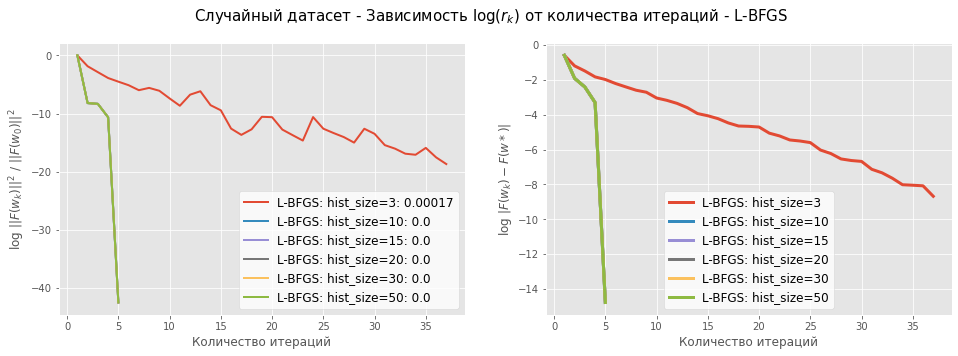

In [25]:
plot_stats(stats_lbfgs_rand, benchmark2, plot_type='iter', 
           title='Случайный датасет - Зависимость $\log{(r_k)}$ от количества итераций - L-BFGS')

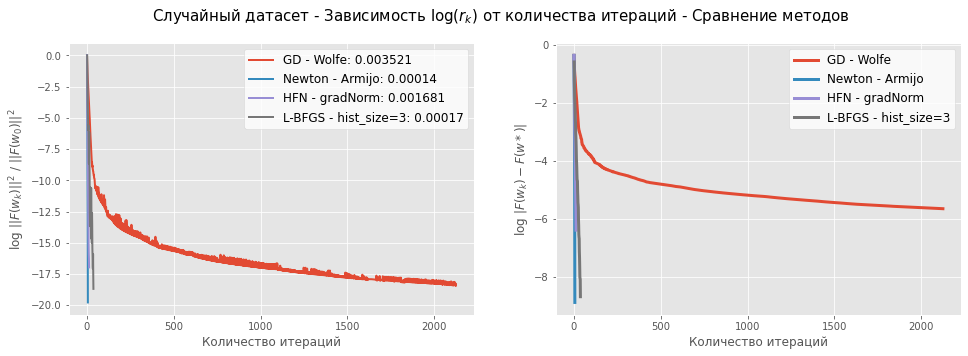

In [26]:
stats_best_rand = dict()
stats_best_rand['GD - Wolfe'] = stats_gd_rand['wolfe']
stats_best_rand['Newton - Armijo'] = stats_newton_rand['armijo']
stats_best_rand['HFN - gradNorm'] = stats_hfn_rand['HFN: gradNorm']
stats_best_rand['L-BFGS - hist_size=3'] = stats_lbfgs_rand['L-BFGS: hist_size=3']
plot_stats(stats_best_rand, benchmark2, plot_type='iter', 
           title='Случайный датасет - Зависимость $\log{(r_k)}$ от количества итераций - Сравнение методов')

- То же самое можно сказать и об этом датасете - датасет небольшой, поэтому можно использовать метод Ньютона без оптимизаций памяти

- Но в целом, L-BFGS, Newton и HFN дают примерно одинаковые результаты

________________________

### Общие выводы о работе методов:

- При увеличении параметра `history_size` точность решения задачи оптимизации увеличивается, т.к. храним больше посчитанных ранее значений, растет и скорость сходимости в плане итераций. Если будем хранить все $n$ значений, то получим __BFGS__ метод со сверхлинейной скоростью сходимости, но потеряем оптимизацию памяти
- Но выбор оптимального значения `history_size` зависит от конкретного датасета и от решаемой задачи. Значения около `history_size=10` дают адекватные результаты для любых начальных приближений и используемых в данной работе датасетов